### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

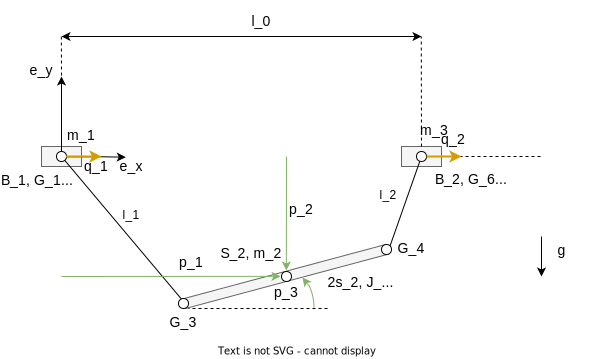

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

aa.T := [a₁  a₂  a₃  a₄]

---

ttheta.T := [p₁  p₂  p₃  q₁  q₂]

---

tthetad.T := [ṗ₁  ṗ₂  ṗ₃  q̇₁  q̇₂]

---

tthetadd.T := [p̈₁  p̈₂  p̈₃  q̈₁  q̈₂]

---

tthetaddd.T := [p⃛₁  p⃛₂  p⃛₃  q⃛₁  q⃛₂]

---

tthetadddd.T := [p⃜₁  p⃜₂  p⃜₃  q⃜₁  q⃜₂]

---

QQ.T := [Q₁  Q₂  Q₃  Q₄  Q₅]

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

B1 := ⎡q₁⎤
⎢  ⎥
⎣0 ⎦

---

B2 := ⎡l₀ + q₂⎤
⎢       ⎥
⎣   0   ⎦

---

G3 := ⎡p₁ - s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ - s₂⋅sin(p₃)⎦

---

G4 := ⎡p₁ + s₂⋅cos(p₃)⎤
⎢               ⎥
⎣p₂ + s₂⋅sin(p₃)⎦

---

(Sd1, Sd2, Sd3) := ⎛⎡q̇₁⎤  ⎡ṗ₁⎤  ⎡q̇₂⎤⎞
⎜⎢  ⎥, ⎢  ⎥, ⎢  ⎥⎟
⎝⎣0 ⎦  ⎣ṗ₂⎦  ⎣0 ⎦⎠

---

In [6]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0] + J2/2 * (pdot3)**2
T3 = (m3/2 * Sd3.T*Sd3)[0]

T = T1 + T2 + T3 ##:

# potential energy
V = m2*g*S2[1] ##:

---

---

this model is very easy ...

In [7]:

mod = mt.generate_symbolic_model(T, V, ttheta, QQ)
mod.eqns

⎡   -Q₁ + m₂⋅p̈₁    ⎤
⎢                  ⎥
⎢-Q₂ + g⋅m₂ + m₂⋅p̈₂⎥
⎢                  ⎥
⎢    J₂⋅p̈₃ - Q₃    ⎥
⎢                  ⎥
⎢   -Q₄ + m₁⋅q̈₁    ⎥
⎢                  ⎥
⎣   -Q₅ + m₃⋅q̈₂    ⎦

... but $Q_i$ are yet unknown → calculate them via the principle of virtual work, see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Generalized_forces#Virtual_work):
$$
\delta W = \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_1} \delta q_1 +\ldots + \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_m} \delta q_m.
$$

- $ \mathbf {F}_{i}$ applied forces, i.e.  $i=1,2$ → cart-forces, $i=3,4$ → rope-foces
- $ \mathbf {r}_{i}$ position vectors of each particle (along the direction of forces): $i=1,3$ → cart, $i=2$ → load
- $ \mathbf {\delta r}_{i}$ virtual displacement
- $ \mathbf \delta q_{j} = \delta \theta_{j}$ virtual displacement of generalized coordinates


The virtual work of a system of particles can be written in the form

$$
    \delta W = Q_1\delta q_1 + \ldots + Q_m\delta q_m,
$$
where

$$
    Q_j = \sum_{i=1}^n \frac {\partial \mathbf {r}_i} {\partial q_j} \cdot \mathbf {F}_{i}  ,\quad j=1,\ldots, m, 
$$

In [8]:
F1 = sp.Matrix([tau1, 0])  ##:T
F2 = sp.Matrix([tau2, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope1 = (G3 - S1)
rope2 = (G4 - S3)
uv_rope1 = rope1/sp.sqrt((rope1.T*rope1)[0])
uv_rope2 = rope2/sp.sqrt((rope2.T*rope2)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope1 = rope1/l1
uv_rope2 = rope2/l2

F3 = uv_rope1 * tau3 ##:
F4 = uv_rope2 * tau4 ##:

F1.T := [τ₁  0]

---

F2.T := [τ₂  0]

---

F3 := ⎡τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))⎤
⎢─────────────────────────⎥
⎢            l₁           ⎥
⎢                         ⎥
⎢  τ₃⋅(p₂ - s₂⋅sin(p₃))   ⎥
⎢  ────────────────────   ⎥
⎣           l₁            ⎦

---

F4 := ⎡τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⎤
⎢───────────────────────────────⎥
⎢               l₂              ⎥
⎢                               ⎥
⎢     τ₄⋅(p₂ + s₂⋅sin(p₃))      ⎥
⎢     ────────────────────      ⎥
⎣              l₂               ⎦

---

In [9]:
dt1, dt2, dt3, dt4, dt5 = ddelta_theta = st.symb_vector(f"\\delta\\theta_1:{n+1}") ##:

ddelta_theta := ⎡\delta\theta₁⎤
⎢             ⎥
⎢\delta\theta₂⎥
⎢             ⎥
⎢\delta\theta₃⎥
⎢             ⎥
⎢\delta\theta₄⎥
⎢             ⎥
⎣\delta\theta₅⎦

---

In [10]:
ttheta

⎡p₁⎤
⎢  ⎥
⎢p₂⎥
⎢  ⎥
⎢p₃⎥
⎢  ⎥
⎢q₁⎥
⎢  ⎥
⎣q₂⎦

#### Attention:
First expressions in $l_1, l_2$ are used instead of $\mathbf{\theta}$ to keep equations simple for SymPy manipulations.

In [11]:
delta_S1 = S1*0
delta_S3 = S3*0

delta_G3 = G3*0 
delta_G4 = G4*0



for theta, delta_theta in zip(ttheta, ddelta_theta):
    
    delta_S1 += S1.diff(theta)*delta_theta
    delta_S3 += S3.diff(theta)*delta_theta
    
    delta_G3 += G3.diff(theta)*delta_theta
    delta_G4 += G4.diff(theta)*delta_theta
    
delta_S1 ##:
delta_S3 ##:

delta_G3 ##:
delta_G4 ##:

(delta_S1) := ⎡\delta\theta₄⎤
⎢             ⎥
⎣      0      ⎦

---

(delta_S3) := ⎡\delta\theta₅⎤
⎢             ⎥
⎣      0      ⎦

---

(delta_G3) := ⎡\delta\theta₁ + \delta\theta₃⋅s₂⋅sin(p₃)⎤
⎢                                        ⎥
⎣\delta\theta₂ - \delta\theta₃⋅s₂⋅cos(p₃)⎦

---

(delta_G4) := ⎡\delta\theta₁ - \delta\theta₃⋅s₂⋅sin(p₃)⎤
⎢                                        ⎥
⎣\delta\theta₂ + \delta\theta₃⋅s₂⋅cos(p₃)⎦

---

In [12]:
# simple part (carts)
delta_W = delta_S1.T*F1 + delta_S3.T*F2 ##:

# rope1 (F3 > 0 means rope is pushing from S1 towards G3)
delta_W = delta_W + delta_G3.T*F3 - delta_S1.T*F3 ##:

# rope2 (F4 > 0 means rope is pushing from S3 towards G4)
delta_W = delta_W + delta_G4.T*F4 - delta_S3.T*F4 ##:

# convert from 1x1 Matrix to scalar:
# delta_W = delta_W[0, 0] ##:

delta_W := [\delta\theta₄⋅τ₁ + \delta\theta₅⋅τ₂]

---

delta_W := ⎡                   \delta\theta₄⋅τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))                   
⎢\delta\theta₄⋅τ₁ - ─────────────────────────────────────── + \delta\theta₅⋅τ₂
⎣                                      l₁                                     

   τ₃⋅(\delta\theta₁ + \delta\theta₃⋅s₂⋅sin(p₃))⋅(p₁ - q₁ - s₂⋅cos(p₃))   τ₃⋅(
 + ──────────────────────────────────────────────────────────────────── + ────
                                    l₁                                        

\delta\theta₂ - \delta\theta₃⋅s₂⋅cos(p₃))⋅(p₂ - s₂⋅sin(p₃))⎤
───────────────────────────────────────────────────────────⎥
                           l₁                              ⎦

---

delta_W := ⎡                   \delta\theta₄⋅τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))                   
⎢\delta\theta₄⋅τ₁ - ─────────────────────────────────────── + \delta\theta₅⋅τ₂
⎣                                      l₁                                     

   \delta\theta₅⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))   τ₄⋅(\delta\theta₁ - \delta\
 - ───────────────────────────────────────────── + ───────────────────────────
                         l₂                                                   

theta₃⋅s₂⋅sin(p₃))⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))   τ₄⋅(\delta\theta₂ + \delta\t
─────────────────────────────────────────────── + ────────────────────────────
         l₂                                                                   

heta₃⋅s₂⋅cos(p₃))⋅(p₂ + s₂⋅sin(p₃))   τ₃⋅(\delta\theta₁ + \delta\theta₃⋅s₂⋅sin
─────────────────────────────────── + ────────────────────────────────────────
   l₂                                                                  l₁     

(p₃))⋅(p₁ - q₁ - s₂⋅cos(p₃))   τ₃⋅(\d

---

In [13]:
QQ_expr = delta_W.jacobian(ddelta_theta).T ##:

QQ_expr := ⎡                                             τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃)) 
⎢                                             ─────────────────────────────── 
⎢                                                            l₂               
⎢                                                                             
⎢                                                     τ₄⋅(p₂ + s₂⋅sin(p₃))   τ
⎢                                                     ──────────────────── + ─
⎢                                                              l₂             
⎢                                                                             
⎢s₂⋅τ₄⋅(p₂ + s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⋅sin(p₃) 
⎢─────────────────────────────── - ────────────────────────────────────────── 
⎢               l₂                                     l₂                     
⎢                                                                             
⎢                                        

---

In [14]:
mod.eqns

⎡   -Q₁ + m₂⋅p̈₁    ⎤
⎢                  ⎥
⎢-Q₂ + g⋅m₂ + m₂⋅p̈₂⎥
⎢                  ⎥
⎢    J₂⋅p̈₃ - Q₃    ⎥
⎢                  ⎥
⎢   -Q₄ + m₁⋅q̈₁    ⎥
⎢                  ⎥
⎣   -Q₅ + m₃⋅q̈₂    ⎦

In [15]:
eqns = mod.eqns.subz(QQ, QQ_expr) ##:

eqns := ⎡                                                     τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅c
⎢                                             m₂⋅p̈₁ - ───────────────────────
⎢                                                                    l₂       
⎢                                                                             
⎢                                                                τ₄⋅(p₂ + s₂⋅s
⎢                                                 g⋅m₂ + m₂⋅p̈₂ - ────────────
⎢                                                                         l₂  
⎢                                                                             
⎢        s₂⋅τ₄⋅(p₂ + s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⋅
⎢J₂⋅p̈₃ - ─────────────────────────────── + ──────────────────────────────────
⎢                       l₂                                     l₂             
⎢                                                                             
⎢                                           

---

In [16]:
eqns.jacobian(ttau)

⎡                            -(p₁ - q₁ - s₂⋅cos(p₃))                          
⎢0   0                       ────────────────────────                         
⎢                                       l₁                                    
⎢                                                                             
⎢                              -(p₂ - s₂⋅sin(p₃))                             
⎢0   0                         ───────────────────                            
⎢                                       l₁                                    
⎢                                                                             
⎢        s₂⋅(p₂ - s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅(p₁ - q₁ - s₂⋅cos(p₃))⋅sin(p₃)    s
⎢0   0   ──────────────────────────── - ─────────────────────────────────  - ─
⎢                     l₁                                l₁                    
⎢                                                                             
⎢                              p₁ - q₁ - s₂⋅cos(p₃) 

In [17]:
# eliminate the last two equations and tau1,2 → 3 remaining

In [18]:
eqns1 = eqns[:-2, :] ##:

eqns1 := ⎡                                                     τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅c
⎢                                             m₂⋅p̈₁ - ───────────────────────
⎢                                                                    l₂       
⎢                                                                             
⎢                                                                τ₄⋅(p₂ + s₂⋅s
⎢                                                 g⋅m₂ + m₂⋅p̈₂ - ────────────
⎢                                                                         l₂  
⎢                                                                             
⎢        s₂⋅τ₄⋅(p₂ + s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅τ₄⋅(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))⋅
⎢J₂⋅p̈₃ - ─────────────────────────────── + ──────────────────────────────────
⎣                       l₂                                     l₂             

os(p₃))   τ₃⋅(p₁ - q₁ - s₂⋅cos(p₃))                                           
──────── - ─────────────────────────      

---

In [19]:
# TODO: Warum können tau1,2 eliminiert werden -> Zshg. zu eqns erste beiden Spalten!
ttau1 = ttau[2:, :] ##:

ttau1 := ⎡τ₃⎤
⎢  ⎥
⎣τ₄⎦

---

now we have two inputs distributed over three equations. The $3\times 2$ coefficient matrix $B_1$ is the following:

In [20]:
B1 = eqns1.jacobian(ttau1) ##:

B1 := ⎡                    -(p₁ - q₁ - s₂⋅cos(p₃))                                  
⎢                    ────────────────────────                                 
⎢                               l₁                                            
⎢                                                                             
⎢                      -(p₂ - s₂⋅sin(p₃))                                     
⎢                      ───────────────────                                    
⎢                               l₁                                            
⎢                                                                             
⎢s₂⋅(p₂ - s₂⋅sin(p₃))⋅cos(p₃)   s₂⋅(p₁ - q₁ - s₂⋅cos(p₃))⋅sin(p₃)    s₂⋅(p₂ + 
⎢──────────────────────────── - ─────────────────────────────────  - ─────────
⎣             l₁                                l₁                            

          -(-l₀ + p₁ - q₂ + s₂⋅cos(p₃))                      ⎤
          ──────────────────────────────                     

---

We need its left pseudoinverse, i.e. the $2 \times 3$ matrix $B_1^{L+}$ with $B_1^{L+} B_1 = I_2$ and its left Orthocomplement $B_1^{L\perp}$ ($1 \times 3$) with $B_1^{L\perp} B_1 = 0_{1 \times 2}$

Note: both matrices are not unique: There are infinitely many Pseudoinverses and Othocomplements.

In [21]:
B1pinv = B1[:2, :].inverse_ADJ() # this is 2 x 2
B1pinv = st.col_stack(B1pinv, sp.Matrix([0, 0])) ##:

B1pinv.shape ##:

B1pinv := ⎡                                              ⎛  p₂   s₂⋅sin(p₃)⎞            
⎢                                        l₁⋅l₂⋅⎜- ── - ──────────⎟            
⎢                                              ⎝  l₂       l₂    ⎠            
⎢─────────────────────────────────────────────────────────────────────────────
⎢l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂⋅s₂⋅cos(p₃) - q
⎢                                                                             
⎢                                               ⎛p₂   s₂⋅sin(p₃)⎞             
⎢                                         l₁⋅l₂⋅⎜── - ──────────⎟             
⎢                                               ⎝l₁       l₁    ⎠             
⎢─────────────────────────────────────────────────────────────────────────────
⎣l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂⋅s₂⋅cos(p₃) - q

                                                                              
                                         

---

---

In [22]:
# check
tmp = (B1pinv * B1).smplf ##:


assert tmp == sp.eye(2)

tmp := ⎡1  0⎤
⎢    ⎥
⎣0  1⎦

---

In [23]:
# nullspace(~kernel) (orthocomplement)
# A matrix in place represents B before substituting exact elements of B
A = st.symbMatrix(3, 2)##:

A := ⎡a₁₁  a₁₂⎤
⎢        ⎥
⎢a₂₁  a₂₂⎥
⎢        ⎥
⎣a₃₁  a₃₂⎦

---

In [24]:
A_ortho = st.nullspaceMatrix(A.T).T ##:

A_ortho := [a₂₁⋅a₃₂ - a₂₂⋅a₃₁  -a₁₁⋅a₃₂ + a₁₂⋅a₃₁  a₁₁⋅a₂₂ - a₁₂⋅a₂₁]

---

In [25]:
# check

(A.T * A_ortho.T).smplf

⎡0⎤
⎢ ⎥
⎣0⎦

In [26]:
# TODO: Was passiert hier genau bzw. wieso?
B1_ortho = A_ortho.subz(list(A), list(B1)).smplf*l1*l2 ##:

B1_ortho := ⎡   ⎛                         2                             2                 
⎣s₂⋅⎝l₀⋅p₂⋅sin(p₃) - l₀⋅s₂⋅sin (p₃) - 2⋅p₁⋅p₂⋅sin(p₃) + 2⋅p₂ ⋅cos(p₃) + p₂⋅q₁⋅

                                   2                2    ⎞                    
sin(p₃) + p₂⋅q₂⋅sin(p₃) + q₁⋅s₂⋅sin (p₃) - q₂⋅s₂⋅sin (p₃)⎠  s₂⋅((-p₁ + q₁ + s₂

                                                                              
⋅cos(p₃))⋅(l₀⋅sin(p₃) - p₁⋅sin(p₃) + p₂⋅cos(p₃) + q₂⋅sin(p₃)) + (-p₁⋅sin(p₃) +

                                                                              
 p₂⋅cos(p₃) + q₁⋅sin(p₃))⋅(l₀ - p₁ + q₂ - s₂⋅cos(p₃)))  (p₂ - s₂⋅sin(p₃))⋅(l₀ 

                                                                   ⎤
- p₁ + q₂ - s₂⋅cos(p₃)) - (p₂ + s₂⋅sin(p₃))⋅(-p₁ + q₁ + s₂⋅cos(p₃))⎦

---

In [27]:
# check orthocomplement property:
res = (B1_ortho * B1).smplf ##:
assert not any(res)

res := [0  0]

---

Now we can assemble the $3\times 3$ transformation matrix:

$$
W_1 = 
\left(\begin{matrix}
B_1^{L+} \\
B_1^{L\perp}
\end{matrix} \right)
$$

In [28]:
W1 = st.row_stack(B1pinv, B1_ortho) ##:i

info(W1) := "<class 'sympy.matrices.dense.MutableDenseMatrix'> with count_ops: Matrix([[37, 36, 0], [36, 34, 0], [38, 33, 19]])"

---

In [29]:
W1

⎡                                                             ⎛  p₂   s₂⋅sin(p
⎢                                                       l₁⋅l₂⋅⎜- ── - ────────
⎢                                                             ⎝  l₂       l₂  
⎢               ──────────────────────────────────────────────────────────────
⎢               l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂
⎢                                                                             
⎢                                                              ⎛p₂   s₂⋅sin(p₃
⎢                                                        l₁⋅l₂⋅⎜── - ─────────
⎢                                                              ⎝l₁       l₁   
⎢               ──────────────────────────────────────────────────────────────
⎢               l₀⋅p₂ - l₀⋅s₂⋅sin(p₃) + 2⋅p₁⋅s₂⋅sin(p₃) - p₂⋅q₁ + p₂⋅q₂ - 2⋅p₂
⎢                                                                             
⎢   ⎛                         2                     

In [30]:
eqns2 = (W1*eqns1).smplf ##:

eqns2 := ⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢s₂⋅((-p₁ + q₁ + s₂⋅cos(p₃))⋅(l₀⋅sin(p₃) - p₁⋅sin(p₃) + p₂⋅cos(p₃) + q₂⋅sin(p₃
⎢─────────────────────────────────────────────────────────────────────────────
⎣                                                                             

                                          

---

In [31]:
ttau1

⎡τ₃⎤
⎢  ⎥
⎣τ₄⎦

In [32]:
B2 = eqns2.jacobian(ttau1).smplf ##:
assert B2 == sp.eye(3)[:, :2]

B2 := ⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎣0  0⎦

---

In [33]:
# eliminate the first two equations and tau3, tau4
eqn3 = eqns2[-1, 0] *l1*l2 ##:

---

In [34]:
eqn3.expand().s

In `eqn3` $q_1, q_2$ only occur algebraicly:  the structure is $0 = \kappa_0 + \kappa_{1, 0} q_1+ \kappa_{0,1} q_2 + \kappa_{1, 1} q_1 q_2$. Thus, $q_2$ (or $q_1$) can be eliminated, together with the last equation.

The remaining quantities form the flat output: $\mathbf{y} = (p_1, p_2, p_3, q_1)^T$.

All other quantities can be derived from $\mathbf y(\cdot)$: $q_2$ from `eqn3` and then the inputs from the earlier eliminated equations. Togehter the eliminated equations yield the parametrization of the system quantities by the flat output.

In [35]:
kappa_10 = eqn3.diff(q1).subs(q2, 0).smplf
kappa_01 = eqn3.diff(q2).subs(q1, 0).smplf
kappa_11 = eqn3.diff(q1).diff(q2).smplf

In [36]:
kappa_0 = (eqn3 - kappa_10*q1 - kappa_01*q2 - kappa_11*q1*q2).smplf

In [37]:
kk = sp.Matrix([kappa_0, kappa_01, kappa_10, kappa_11])

In [38]:
kk.s

# System parameterization by flat output

In [39]:
flat_q2 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqn3, q2))
flat_q2 = flat_q2.smplf
flat_q2.s ##:

---

In [40]:
# time derivative of q2 used later
flat_qddot2 = st.time_deriv(flat_q2, ttheta, order=2)
flat_qddot2.s ##:

---

In [41]:
flat_tau4 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[1], tau4)) 
flat_tau4 = flat_tau4.subz([l2], [sp.sqrt((rope2.T*rope2)[0])]) # substituting l2 for variable rope length
flat_tau4 = flat_tau4.smplf
flat_tau4 = flat_tau4.subz([q2], flat_q2)
flat_tau4.s ##:

---

In [42]:
flat_tau3 =  sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[0], tau3)) 
flat_tau3 = flat_tau3.subz([q2], flat_q2)
flat_tau3 = flat_tau3.smplf
flat_tau3.s ##:

---

In [43]:
flat_tau3 =  sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns2[0], tau3)) 
flat_tau3 = flat_tau3.subz([l1], [sp.sqrt((rope1.T*rope1)[0])]) # substituting l1 for variable rope length
flat_tau3 = flat_tau3.smplf
flat_tau3 = flat_tau3.subz([q2], flat_q2)
flat_tau3 = flat_tau3.smplf
flat_tau3.s ##:

---

In [44]:
flat_tau2 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns[-1], tau2))
flat_tau2 = flat_tau2.subz([l2], [sp.sqrt((rope2.T*rope2)[0])]) # substituting l2 for variable rope length
flat_tau2 = flat_tau2.smplf
flat_tau2.s ##:
flat_tau2 = flat_tau2.subz([q2, qddot2, tau4, tau3], [*flat_q2, *flat_qddot2, *flat_tau4, *flat_tau3])
flat_tau2.s ##:

---

---

In [45]:
flat_tau1 = sp.matrices.dense.MutableDenseMatrix(sp.solve(eqns[-2], tau1))
flat_tau1 = flat_tau1.subz([l1], [sp.sqrt((rope1.T*rope1)[0])]) # substituting l1 for variable rope length
flat_tau1 = flat_tau1.smplf
flat_tau1 = flat_tau1.subz([q2, tau4, tau3], [*flat_q2, *flat_tau4, *flat_tau3])
flat_tau1.s ##:

---

# State feedback for control

In [46]:
# define error symbols
p_error = st.symb_vector("pe1:{0}".format(3+1)) # error vector of passive coordinates
q_error = st.symb_vector("qe1:{0}".format(2+1)) # error vector of actuated coordinates

error_states = st.row_stack(p_error, q_error)
error_states_d = st.time_deriv(error_states, error_states)
error_states_dd = st.time_deriv(error_states, error_states, order=2)
error_states_ddd = st.time_deriv(error_states, error_states, order=3)
error_states_dddd = st.time_deriv(error_states, error_states, order=4)

st.make_global(error_states, error_states_d, error_states_dd, error_states_ddd, error_states_dddd)

# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas)
meas_states_d = st.time_deriv(meas_states, meas_states)
meas_states_dd = st.time_deriv(meas_states, meas_states, order=2)
meas_states_ddd = st.time_deriv(meas_states, meas_states, order=3)
meas_states_dddd = st.time_deriv(meas_states, meas_states, order=4)

st.make_global(meas_states, meas_states_d, meas_states_dd, meas_states_ddd, meas_states_dddd)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

#### Linear feedback error:
$$
e := y - y_{\text{ref}}
$$

#### Error dynamics:
$$
e^{(n)} + c_{n-1} e^{(n-1)} + ... + c_{1} \dot{e} + c_{0} e = 0 
\Leftrightarrow y^{(n)} = y_{\text{ref}}^{(n)} - c_{n-1} e^{(n-1)} - ... - c_{1} \dot{e} - c_{0} e
$$

In [278]:
# coefficients for error dynamics
# Polynome: s^2 + c_i[1] s + c_i[0] s
cp1 = [1, 2]
cp2 = [1, 2]
cp3 = [1, 2]
cq1 = [1, 2]
c2 = sp.Matrix([cp1, cp2, cp3, cq1, [0, 0]])

Every component of the flat output $\mathbf{y}$ appearing in $\mathbf{\tau}$ with a higher order derivative than 1 has to be substituted, becaus it is assumed that only positions and speeds of $\mathbf{y}$ can be measured directly.

##### Quasi static state feedback:
\begin{align}
    \ddot{e} + c_1 \dot{e} + c_0 e &= 0 \\
    e^{(3)} + c_1 \ddot{e} + c_0 \dot{e} &= 0 \\
    e^{(3)} + c_1 (-c_1 \dot{e} - c_0 e) + c_0 \dot{e} &= 0 \\
    e^{(3)} - c_1^2 \dot{e} + c_0 \dot{e} - c_0 c_1 e &= 0 \\
    e^{(3)} + (c_0 - c_1^2) \dot{e} - c_0 c_1 e &= 0 \\
    e^{(4)} + (c_0 - c_1^2) \ddot{e} - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_0 - c_1^2) (-c_1 \dot{e} - c_0 e) - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_1^2 - 2 c_0 c_1) \dot{e} + (c_0 c_1^2 - c_0^2) e &= 0 \\
    \Rightarrow y^{(3)} &= y_{\text{ref}}^{(3)} - (c_0 - c_1^2) \dot{e} + c_0 c_1 e \\
    \Rightarrow y^{(4)} &= y_{\text{ref}}^{(4)} - (c_1^3 - 2 c_0 c_1) \dot{e} - (c_0 c_1^2 - c_0^2) e
\end{align}

In [279]:
from sympy.matrices.dense import matrix_multiply_elementwise as elmul

In [280]:
c2_00 = elmul(c2[:, 0], c2[:, 0])
c2_01 = elmul(c2[:, 0], c2[:, 1])
c2_11 = elmul(c2[:, 1], c2[:, 1])
c2_111 = elmul(elmul(c2[:, 1], c2[:, 1]), c2[:, 1])
c2_011 = elmul(elmul(c2[:, 0], c2[:, 1]), c2[:, 1])

In [281]:
meas_subs_dd = ref_states_dd - elmul(c2[:, 1], (meas_states_d - ref_states_d)) - elmul(c2[:, 0], (meas_states - ref_states)) ##:

meas_subs_dd := ⎡-pm₁ - 2⋅pṁ₁ + pr₁ + pr̈₁ + 2⋅pṙ₁⎤
⎢                                ⎥
⎢-pm₂ - 2⋅pṁ₂ + pr₂ + pr̈₂ + 2⋅pṙ₂⎥
⎢                                ⎥
⎢-pm₃ - 2⋅pṁ₃ + pr₃ + pr̈₃ + 2⋅pṙ₃⎥
⎢                                ⎥
⎢-qm₁ - 2⋅qṁ₁ + qr₁ + qr̈₁ + 2⋅qṙ₁⎥
⎢                                ⎥
⎣              qr̈₂               ⎦

---

In [282]:
# for quasi static state feedback approach
meas_subs_ddd = ref_states_ddd - elmul((c2[:, 0] - c2_11), (meas_states_d - ref_states_d)) + elmul(c2_01, (meas_states - ref_states))
meas_subs_dddd = ref_states_dddd - elmul((c2_111 - 2*c2_01), (meas_states_d - ref_states_d)) - elmul((c2_011 - c2_00), (meas_states - ref_states))

In [283]:
flat_tau1.s ##:
flat_tau1_control = flat_tau1.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
flat_tau1_control.s ##:
# resubstitute reference trajectory states as default pi, q 
flat_tau1_control = flat_tau1_control.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])
flat_tau1_control.s ##:

---

---

---

In [284]:
meas_subs_dddd

⎡-3⋅pm₁ - 4⋅pṁ₁ + 3⋅pr₁ + pr⃜₁ + 4⋅pṙ₁⎤
⎢                                    ⎥
⎢-3⋅pm₂ - 4⋅pṁ₂ + 3⋅pr₂ + pr⃜₂ + 4⋅pṙ₂⎥
⎢                                    ⎥
⎢-3⋅pm₃ - 4⋅pṁ₃ + 3⋅pr₃ + pr⃜₃ + 4⋅pṙ₃⎥
⎢                                    ⎥
⎢-3⋅qm₁ - 4⋅qṁ₁ + 3⋅qr₁ + qr⃜₁ + 4⋅qṙ₁⎥
⎢                                    ⎥
⎣                qr⃜₂                 ⎦

In [285]:
meas_subs_ddd

⎡2⋅pm₁ + 3⋅pṁ₁ - 2⋅pr₁ + pr⃛₁ - 3⋅pṙ₁⎤
⎢                                   ⎥
⎢2⋅pm₂ + 3⋅pṁ₂ - 2⋅pr₂ + pr⃛₂ - 3⋅pṙ₂⎥
⎢                                   ⎥
⎢2⋅pm₃ + 3⋅pṁ₃ - 2⋅pr₃ + pr⃛₃ - 3⋅pṙ₃⎥
⎢                                   ⎥
⎢2⋅qm₁ + 3⋅qṁ₁ - 2⋅qr₁ + qr⃛₁ - 3⋅qṙ₁⎥
⎢                                   ⎥
⎣                qr⃛₂                ⎦

In [387]:
flat_tau2.s ##:
#flat_tau2_control = flat_tau2.subz([pddddot1, pddddot3, qddddot1, pdddot1, pdddot3, qdddot1, pddot1, pddot3, qddot1], [meas_subs_dddd[0], meas_subs_dddd[2], meas_subs_dddd[3], meas_subs_ddd[0], meas_subs_ddd[2], meas_subs_ddd[3], meas_subs_dd[0], meas_subs_dd[2], meas_subs_dd[3]])
flat_tau2_control = flat_tau2.subz([pddot3, pdddot3, pddddot3, qddot1], [meas_subs_dd[2], meas_subs_ddd[2], meas_subs_dddd[2], meas_subs_dd[3]])
flat_tau2_control.s ##:
# substitute all measured states for feedback control
flat_tau2_control = flat_tau2_control.subz([*tthetad, *ttheta], [*meas_states_d, *meas_states])
# resubstitute reference trajectory states as default pi, q
flat_tau2_control = flat_tau2_control.subz([*ref_states_dddd, *ref_states_ddd, *ref_states_dd, *ref_states_d, *ref_states], [*tthetadddd, *tthetaddd, *tthetadd, *tthetad, *ttheta])
flat_tau2_control.s ##:

---

---

---

In [388]:
flat_tau3.s ##:
flat_tau3_control = flat_tau3.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
flat_tau3_control.s ##:
# resubstitute reference trajectory states as default pi, q 
flat_tau3_control = flat_tau3_control.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])
flat_tau3_control.s ##:

---

---

---

In [389]:
flat_tau4.s ##:
flat_tau4_control = flat_tau4.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
flat_tau4_control.s ##:
# resubstitute reference trajectory states as default pi, q 
flat_tau4_control = flat_tau4_control.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])
flat_tau4_control.s ##:

---

---

---

In [390]:
# resubstitute the rope lengths:
mod.eqns = eqns.subz([l1, l2], [sp.sqrt((rope1.T*rope1)[0]), sp.sqrt((rope2.T*rope2)[0])])

In [391]:
mod.eqns

⎡                                                                           τ₃
⎢                                                       m₂⋅p̈₁ - ─────────────
⎢                                                                  ___________
⎢                                                                 ╱           
⎢                                                               ╲╱  (p₂ - s₂⋅s
⎢                                                                             
⎢                                                                             
⎢                                                   g⋅m₂ + m₂⋅p̈₂ - ──────────
⎢                                                                     ________
⎢                                                                    ╱        
⎢                                                                  ╲╱  (p₂ - s
⎢                                                                             
⎢                 s₂⋅τ₃⋅(p₂ - s₂⋅sin(p₃))⋅cos(p₃)   

In [392]:
mod.tau = ttau

In [393]:
mod.calc_state_eq(force_recalculation=True)

In [394]:
mod.f

⎡ṗ₁⎤
⎢  ⎥
⎢ṗ₂⎥
⎢  ⎥
⎢ṗ₃⎥
⎢  ⎥
⎢q̇₁⎥
⎢  ⎥
⎢q̇₂⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢-g⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎣0 ⎦

In [395]:
mod.g

⎡0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢                         p₁ - q₁ - s₂⋅cos(p₃)                                
⎢0   0   ─────────────────────────────────────────────────────  ──────────────
⎢              _____________________________________

In [396]:
pickle_data = [mod, eqns, ttau, flat_q2, flat_qddot2, flat_tau1, flat_tau2, flat_tau3, flat_tau4, flat_tau1_control, flat_tau2_control, flat_tau3_control, flat_tau4_control]

In [397]:
# store with pickle

with open("flatness_analysis_control.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)

#### Determination of  vector relative degree
for reference: Röbenack Nichtlineare Regelungssysteme p. 194 / chapter 4.5

In [381]:
y1 = mod.xx[0]
yd1 = st.lie_deriv(y1, mod.state_eq, mod.xx) ##:
ydd1 = st.lie_deriv(yd1, mod.state_eq, mod.xx)
ydd1.s ##:
r1 = 2

---

---

In [382]:
y2 = mod.xx[1]
yd2 = st.lie_deriv(y2, mod.state_eq, mod.xx) ##:
ydd2 = st.lie_deriv(yd2, mod.state_eq, mod.xx)
ydd2.s ##:
r2 = 2

---

---

In [383]:
y3 = mod.xx[2]
yd3 = st.lie_deriv(y3, mod.state_eq, mod.xx) ##:
ydd3 = st.lie_deriv(yd3, mod.state_eq, mod.xx)
ydd3.s ##:
r3 = 2

---

---

In [384]:
y4 = mod.xx[3]
yd4 = st.lie_deriv(y4, mod.state_eq, mod.xx) ##:
ydd4 = st.lie_deriv(yd4, mod.state_eq, mod.xx)
ydd4.s ##:
r4 = 2

---

---

#### Conclusion:
All components of the vector relative degree have the value $r_i = 2$. This implies an error dynamic of order 2 for each component of the flat output $\mathbf{y}$. This is in contradiction to the earlier found algebraic solution for $\tau_2$ including error dynamics of order 4 in $p_i$.   

In [385]:
mod.g

⎡0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢0   0                             0                                          
⎢                                                                             
⎢                         p₁ - q₁ - s₂⋅cos(p₃)                                
⎢0   0   ─────────────────────────────────────────────────────  ──────────────
⎢              _____________________________________

In [386]:
# Lambda 1st row 
Lg1_yd1 = st.lie_deriv(yd1, mod.g[:, 0], mod.xx) ##: 
Lg2_yd1 = st.lie_deriv(yd1, mod.g[:, 1], mod.xx) ##:
Lg3_yd1 = st.lie_deriv(yd1, mod.g[:, 2], mod.xx)
Lg4_yd1 = st.lie_deriv(yd1, mod.g[:, 3], mod.xx)
# Lambda 2nd row
Lg1_yd2 = st.lie_deriv(yd2, mod.g[:, 0], mod.xx) ##:
Lg2_yd2 = st.lie_deriv(yd2, mod.g[:, 1], mod.xx) ##:
Lg3_yd2 = st.lie_deriv(yd2, mod.g[:, 2], mod.xx)
Lg4_yd2 = st.lie_deriv(yd2, mod.g[:, 3], mod.xx)
# Lambda 3rd row
Lg1_yd3 = st.lie_deriv(yd3, mod.g[:, 0], mod.xx) ##:
Lg2_yd3 = st.lie_deriv(yd3, mod.g[:, 1], mod.xx) ##:
Lg3_yd3 = st.lie_deriv(yd3, mod.g[:, 2], mod.xx)
Lg4_yd3 = st.lie_deriv(yd3, mod.g[:, 3], mod.xx)
# Lambda 4th row
Lg1_yd4 = st.lie_deriv(yd4, mod.g[:, 0], mod.xx) ##:
Lg2_yd4 = st.lie_deriv(yd4, mod.g[:, 1], mod.xx) ##:
Lg3_yd4 = st.lie_deriv(yd4, mod.g[:, 2], mod.xx)
Lg4_yd4 = st.lie_deriv(yd4, mod.g[:, 3], mod.xx)

---

---

---

---

---

---

---

---

#### Problem: 
1st and 2nd column of $\Lambda$ will be 0. So $\Lambda$ won't be regular. A dynamic or quasi static state feedback becomes necessarry (see corresponding notebooks).